# Info

Workin on:
* 



Gneral gist:

1) read the mtm files. The file allows you to already apply some corrections. However, since I have not the full controll about the program (mtm), I just use it to read the content and spit it out
2) apply corrections, first cosine, than intensity ... I think

In [6]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf

# Workplan

strategy:
my normal strategy will not work here since the raw data is not by day but quite arbitrary, therefore input file data will not match the final output data
1) ✓ determin first and last file
2) ✓ make a daterange from first to last day where there is data
3) ✓ create output file names and paths based on all those days
4) ✓ process all files. MFRSR that is
5) test for MFR data
6) process all MFR data

# Master plan in 

In [2]:
site = 'cbc' #'cbc', 'ckp'
instrument = 'mfrsr'#'mfr10'#'mfrsr'
freq='d'
version = '0.1'

In [3]:
# Get all raw files
basepath = '/nfs/grad/Inst/MFR/Campaign/'
# basepath = '/home/hagen/data/grad/campaign/splash'

p2fld_in = pl.Path(f'{basepath}/{site}/{instrument}/raw/')

p2fld_out = pl.Path(f'{basepath}/{site}/{instrument}/raw.netcdf/v{version}')
p2fld_out.parent.mkdir(exist_ok=True)
p2fld_out.mkdir(exist_ok = True)

df  = pd.DataFrame(p2fld_in.glob('**/*.xmd'), columns=['p2f_in'])
df = df.sort_values('p2f_in')
df['fname'] = df.apply(lambda row: row.p2f_in.name, axis = 1)
mp_in = df

In [4]:
mp_in

,p2f_in,fname
229,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2021...,cbc_mfrsr_20211005_112637.xmd
281,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2021...,cbc_mfrsr_20211005_173115.xmd
88,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2021...,cbc_mfrsr_20211006_002018.xmd
224,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2021...,cbc_mfrsr_20211006_051602.xmd
279,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2021...,cbc_mfrsr_20211006_112450.xmd
...,...,...
616,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2023...,cbc_mfrsr_20230622_120001.xmd
407,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2023...,cbc_mfrsr_20230622_180001.xmd
505,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2023...,cbc_mfrsr_20230623_010001.xmd
809,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2023...,cbc_mfrsr_20230623_060001.xmd


# Masterplan out 

This might not bee needed anymore?

In [7]:
reload(atmsrf)

<module 'atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad' from '/home/grad/htelg/prog_dev/atm-py/atmPy/data_archives/NOAA_ESRL_GMD_GRAD/surfrad/surfrad.py'>

In [8]:
# load very first file to get the earliest datapoint
i=0
while 1:
    print(i)
    if i == 10:
        print('lets not do this')
        break
    try:
        opt = atmsrf.read_raw(mp_in.iloc[i].p2f_in)
        break
    except atmsrf.FileCorruptError:
        i += 1
        continue

start = pd.to_datetime(opt.dataset.datetime.values[0])
start

0
1


Timestamp('2021-10-05 19:42:19.584000172')

In [9]:
# Load the very last file to get the last datapoint
i=1
while 1:
    print(i)
    if i == 10:
        print('lets not do this')
        break
    try:
        opt = atmsrf.read_raw(mp_in.iloc[-i].p2f_in)
        break
    except atmsrf.FileCorruptError:
        i += 1
        continue

end = pd.to_datetime(opt.dataset.datetime.values[-1])
end

1


Timestamp('2023-06-23 19:00:00.287999887')

In [10]:
# data frame with dayly output files
df = pd.DataFrame(index = pd.date_range(start.date(),end.date(), freq=freq), columns = ['p2out'])
df['p2out'] = df.apply(lambda row: p2fld_out.joinpath(f'{site}_{instrument}_{row.name.year:04d}{row.name.month:02d}{row.name.day:02d}.nc'), axis = 1)
mp_out = df
mp_out

,p2out
2021-10-05,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
2021-10-06,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
2021-10-07,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
2021-10-08,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
2021-10-09,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
...,...
2023-06-19,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
2023-06-20,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
2023-06-21,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...
2023-06-22,/nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw.netc...


# check which raw file was the last that was processed

In [38]:
# keep opening files until the start and end of the file are on a different day
def open_next_row(wpiter, verbose = True):
    """ This opens the next readable (non-corrupt) file"""
    while 1:
        row_in = next(wpiter)[1]
        if verbose:
            print(f'open file: {row_in.p2f_in}')
        try:
            dsin = atmsrf.read_raw(row_in.p2f_in)
            break
        except atmsrf.FileCorruptError:
            print(f'Corrupt file encountered: {row_in.p2f_in.as_posix()}.')
            continue
    return dsin 

# get the start and end of the file, keep previous start if this is not the first file.
def daysfromstart(dsin, start_file, whichend = 'end'):
    if whichend == 'end':
        test = pd.to_datetime(dsin.dataset.datetime.values[-1])
    elif whichend == 'start':
        test  = pd.to_datetime(dsin.dataset.datetime.values[0])
    return (test.date() - start_file.date()) / pd.to_timedelta('1d')

def make_file_of_the_day(wpiter, active, start_file, verbose = True):
    ds_rawlist = []
    complete = True
    
    # open a file, but only if none is active from the last loop
    if not active:
        active = open_next_row(wpiter, verbose=verbose)
    
    ds_rawlist.append(active)
    
    # in first loop only
    if not start_file:
        start_file = pd.to_datetime(active.dataset.datetime.values[0].astype('datetime64[D]'))
    
    # check if the file ends on the same day. If so we want to check the next one and see if ends on the next day, while starting on the same day !!!
    noofdays = daysfromstart(active, start_file)
    
    while noofdays == 0:
        if verbose:
            print('file ends the same day, get the next one')
        try:
            active = open_next_row(wpiter, verbose = verbose)
        except StopIteration:
            complete = False
            if verbose:
                print(f'Reached end of file list. This file will be incomplet')
            break
        # Removed the blow: I don't thing it is that concerning when the file is a little longer, it gets concatinated anyway?
        # when the file starts on the next day it should not be included in the list
        # if daysfromstart(active, start_file, whichend='start') == 0:
        
        ds_rawlist.append(active)
        noofdays = daysfromstart(active, start_file)
        
    if verbose:     
        print('more than one day in files, concat and truncate')
    
    # ds_rawlist should now include all files that have data on this day
    # lets concatonate and truncate them
    # concat
    dsout = xr.concat([i.dataset for i in ds_rawlist], 'datetime')
    
    # truncate
    end = start_file + pd.to_timedelta(1,freq) - pd.to_timedelta(1, 'ns')
    
    # print(f'start/end: {start_file}/{end}')
    # global tp_dsout, tp_start_file, tp_end
    # tp_dsout = dsout.copy()
    # tp_start_file = start_file
    # tp_end = end

    dsout = dsout.drop_duplicates('datetime', keep = 'last') # in rare cases the data is present in multiple files
    dsout = dsout.sel(datetime = slice(start_file,end))
    
    dsout.attrs = ds_rawlist[0].dataset.attrs
    dsout.attrs.pop('path2file')
    dsout.attrs['day_complete'] = complete.__str__()
    dsout.attrs['parent_files'] = ', '.join([i.dataset.attrs['path2file'].as_posix() for i in ds_rawlist])
    dsout.attrs['product_version'] = version
    dsout.attrs['info'] = 'Original raw files concatinated/truncated to daily files and converted to netcdf files'
    
    # create the pathname and save under that name
    
    dt = start_file
    p2f_out = p2fld_out.joinpath(f'{site}_{instrument}_{dt.year:04d}{dt.month:02d}{dt.day:02d}.nc')
    
    if dsout.datetime.shape[0] == 0:
        if verbose:
            print('no data in dataset, skip saving')
    else:
        if p2f_out.is_file():
            if verbose:
                print('File exists, skip saving')
        else:
            dsout.to_netcdf(p2f_out)
    return {'dsout': dsout, 'p2f_out': p2f_out, 'active': active, 'start_file': start_file, 'complete': complete}

In [39]:
# Truncate the workplan according what is already been processed
mp_out_exist = mp_out[mp_out.apply(lambda row: row.p2out.is_file(), axis = 1)]

if mp_out_exist.shape[0] == 0:
    print('No rawfiles have been processe yet, start from the beginning')
    wp_in = mp_in
else:
    lastrow = mp_out_exist.iloc[-1]
    ds = xr.open_dataset(lastrow.p2out)

    # check if any new raw files have been produced, if not there is nothing to do
    last_used_rawfile = ds.parent_files.split(',')[-1].strip()
    last_used_rawfile = pl.Path(last_used_rawfile)
    if mp_in.iloc[-1].p2f_in == last_used_rawfile:
        assert(False), 'No new raw files, nothing to do here'
        
    if ds.day_complete == 'True':
        print('Last file was complet')
        #when the day was complet we still want the last file since that file reached into the next day and was truncated
        start_at_this_file = last_used_rawfile
    else:
        print('Last file was incomplet')
        # when the day was not complete we want to start from scratch with this file and load all files that has been used in the last netcdf file
        start_at_this_file = ds.parent_files.split(',')[0].strip()
        start_at_this_file = pl.Path(start_at_this_file)

    rawlable = mp_in.index[mp_in.p2f_in == start_at_this_file][0]
    pos = mp_in.index.get_loc(rawlable)
    wp_in = mp_in.iloc[pos:]

# Keep rocessing
wpiter = wp_in.iterrows()
active = False
start_file = False
complete = True
# endsonsameday = False

i = 0
while complete:
    # print(f'make next file of the day ({i})')
    print('.', end = '')
    out = make_file_of_the_day(wpiter, active, start_file, verbose = False)
    active = out['active']
    complete = out['complete']
    start_file = out['start_file'] + pd.to_timedelta(1, 'd')
    dsout = out['dsout']
    i += 1
    # if i > 30:
    #     break

Last file was complet
.........Corrupt file encountered: /nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2023/cbc_mfrsr_20230322_010001.xmd.
Corrupt file encountered: /nfs/grad/Inst/MFR/Campaign/cbc/mfrsr/raw/2023/cbc_mfrsr_20230322_060001.xmd.
.............................................................................................

In [ ]:
dsout, start_file, end = tp_dsout, tp_start_file, tp_end

In [24]:
dsout.datetime.min(), dsout.datetime.max()

(<xarray.DataArray 'datetime' ()> Size: 8B
 array('2023-03-14T19:01:39.648000207', dtype='datetime64[ns]'),
 <xarray.DataArray 'datetime' ()> Size: 8B
 array('2023-03-16T00:59:40.416000077', dtype='datetime64[ns]'))

In [25]:
start_file, end

(Timestamp('2023-03-15 00:00:00'), Timestamp('2023-03-15 23:59:59.999999999'))

In [34]:
dsoutdd = dsout.drop_duplicates('datetime', keep = 'last')

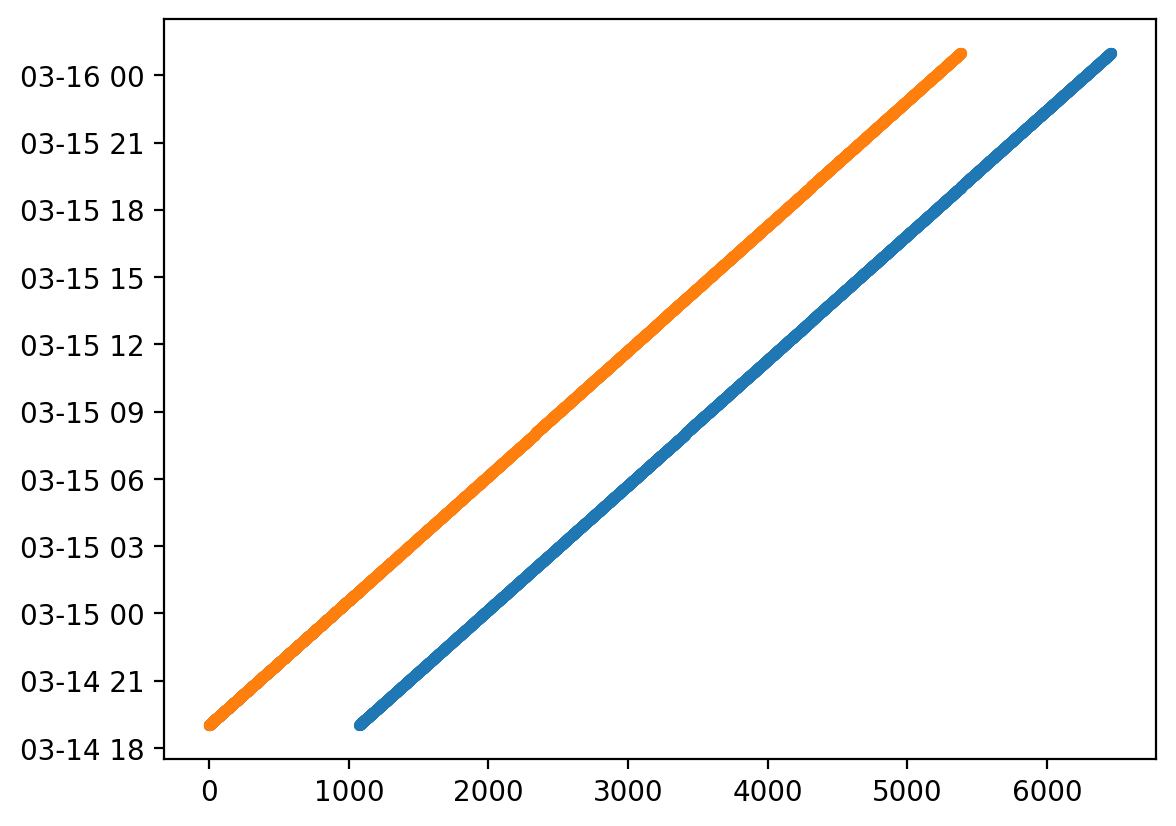

In [35]:
plt.plot(dsout.datetime, ls = '', marker = '.')
plt.plot(dsoutdd.datetime, ls = '', marker = '.')

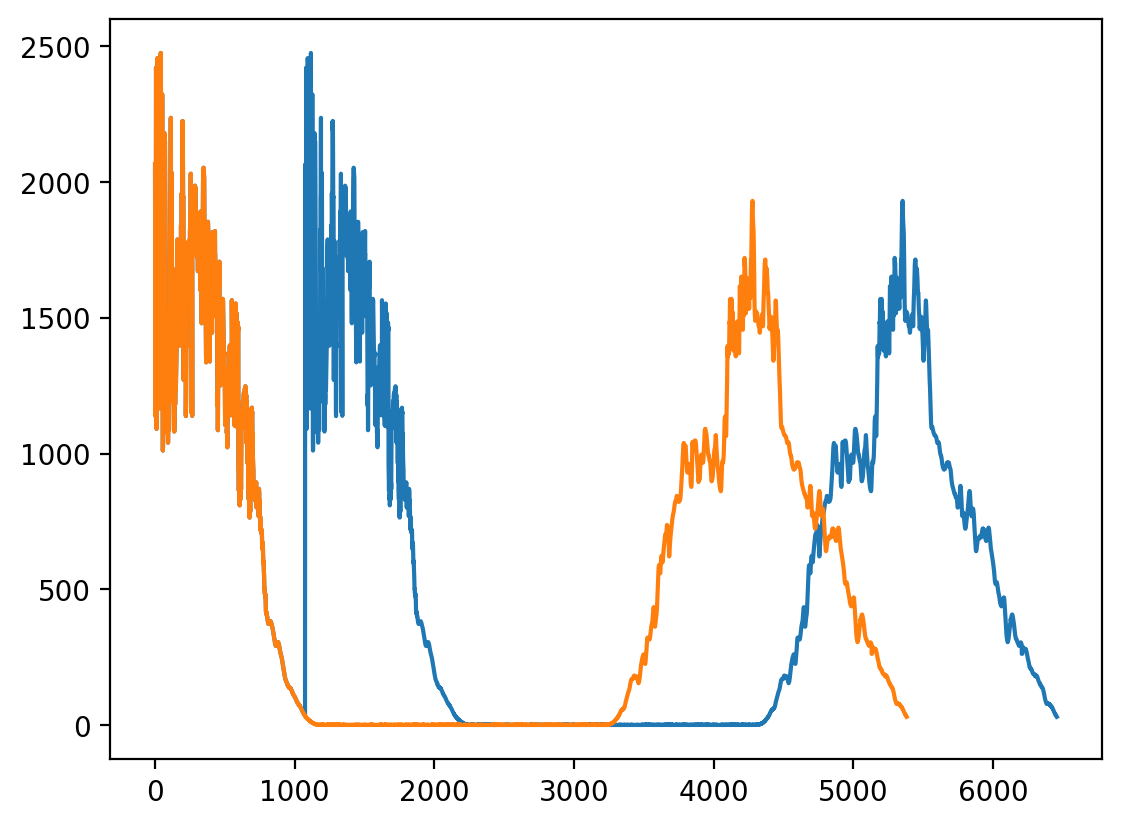

In [36]:
plt.plot(dsout.alltime.sel(channel = 1).values)
plt.plot(dsoutdd.alltime.sel(channel = 1).values)

In [ ]:
dsout = dsout.sel(datetime = slice(start_file,end))

KeyError: "Cannot get left slice bound for non-unique label: Timestamp('2023-03-15 00:00:00')"

## testing

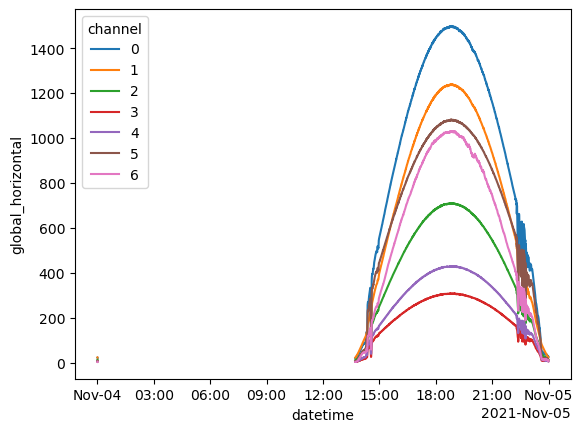

In [209]:
dsout.global_horizontal.plot.line(x = 'datetime')

In [202]:
files = list(pl.Path('/home/hagen/data/grad/campaign/splash/cbc/mfrsr/raw.netcdf/v0.1/').glob('*'))
files.sort()
ds = xr.open_mfdataset(files)

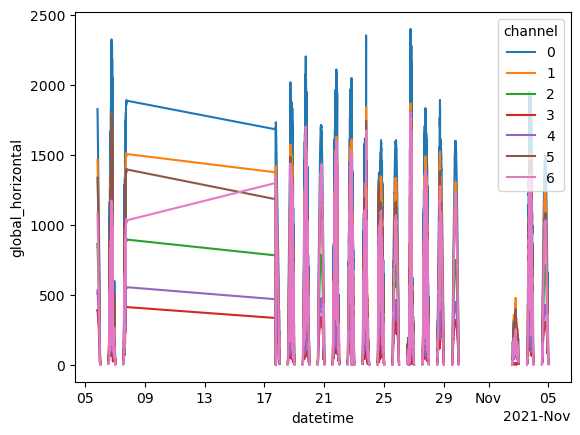

In [205]:
ds.global_horizontal.plot.line(x = 'datetime')

In [192]:
# i = 0
i += 1
ds = xr.open_dataset(files[i])
print(files[i])
ds

/home/hagen/data/grad/campaign/splash/cbc/mfrsr/raw.netcdf/v0.1/cbc_mfrsr_20211008.nc


<xarray.Dataset> Size: 56B
Dimensions:             (datetime: 0, channel: 7)
Coordinates:
  * datetime            (datetime) datetime64[ns] 0B 
  * channel             (channel) int64 56B 0 1 2 3 4 5 6
Data variables:
    alltime             (datetime, channel) int64 0B ...
    global_horizontal   (datetime, channel) int64 0B ...
    diffuse_horizontal  (datetime, channel) int64 0B ...
    direct_normal       (datetime, channel) float64 0B ...
Attributes: (12/13)
    site_longitude:         -106.918945
    site_latitude:          38.853149
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    info:                   Original raw files concatinated/truncated to dail...
    file_type:              13
    serial_no:              BF4F
    day_complete:           True
    parent_files:           /home/hagen/data/grad/campaign/splash/cbc/mfrsr/r...
    product_version:        0.1

In [194]:
ds.datetime.shape[0] == 0

True

In [178]:
ds

<xarray.Dataset> Size: 22kB
Dimensions:             (datetime: 94, channel: 7)
Coordinates:
  * datetime            (datetime) datetime64[ns] 752B 2021-10-06 ... 2021-10...
  * channel             (channel) int64 56B 0 1 2 3 4 5 6
Data variables:
    alltime             (datetime, channel) int64 5kB ...
    global_horizontal   (datetime, channel) float64 5kB ...
    diffuse_horizontal  (datetime, channel) float64 5kB ...
    direct_normal       (datetime, channel) float64 5kB ...
Attributes: (12/13)
    site_longitude:         -104.996338
    site_latitude:          39.995728
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    info:                   Original raw files concatinated/truncated to dail...
    file_type:              13
    serial_no:              BF4F
    day_complete:           True
    parent_files:           /home/hagen/data/grad/campaign/splash/cbc/mfrsr/r...
    product_version:        0.1

In [188]:
wp_in.iloc[:10]

,p2f_in,fname
728,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211005_112637.xmd
964,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211005_173115.xmd
806,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211006_002018.xmd
857,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211006_051602.xmd
691,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211006_112450.xmd
777,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211006_173029.xmd
954,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211007_002202.xmd
791,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211007_051556.xmd
816,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211007_112647.xmd
959,/home/hagen/data/grad/campaign/splash/cbc/mfrs...,cbc_mfrsr_20211017_112505.xmd


# NEXT: Does this also work for the MFR10 data?

# read mtm file

## mfr (mfr10)

In [42]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf

In [116]:
reload(atmsrf)

<module 'atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad' from '/home/hagen/prog/atm-py/atmPy/data_archives/NOAA_ESRL_GMD_GRAD/surfrad/surfrad.py'>

In [117]:
# p2fld = pl.Path('/nfs/grad/Inst/MFR/SURFRAD/tbl/mfr10')
p2fld = pl.Path('/home/hagen/data/grad/campaign/splash/cbc/mfr10/raw/2022/cbc_mfr10_20220107_182547.xmd')

In [118]:
out = atmsrf.read_raw(p2fld, 
                      # test=1,
                     )
# df, header = out

In [120]:
out.dataset

<xarray.Dataset> Size: 69kB
Dimensions:   (datetime: 1070, channel: 7)
Coordinates:
  * datetime  (datetime) datetime64[ns] 9kB 2022-01-07T19:29:20.255999749 ......
  * channel   (channel) int64 56B 0 1 2 3 4 5 6
Data variables:
    alltime   (datetime, channel) int64 60kB 1114 1234 622 31 417 ... 0 -1 -1 -1
Attributes: (12/13)
    site_longitude:         -106.918945
    site_latitude:          38.853149
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    info:                   This is the raw file
    file_type:              13
    serial_no:              C8C1
    path2file:              /home/hagen/data/grad/campaign/splash/cbc/mfr10/r...
    measurement_sequenc:    0, 20, 20
    instrument_type:        mfr

In [121]:
# p2fld = pl.Path('/nfs/grad/Inst/MFR/SURFRAD/tbl/mfr10')
p2fld = pl.Path('/home/hagen/data/grad/campaign/splash/cbc/mfrsr/raw/2022/cbc_mfrsr_20220107_182352.xmd')
outt = atmsrf.read_raw(p2fld, 
                       # test=1
                      )
# dft, headert = outt

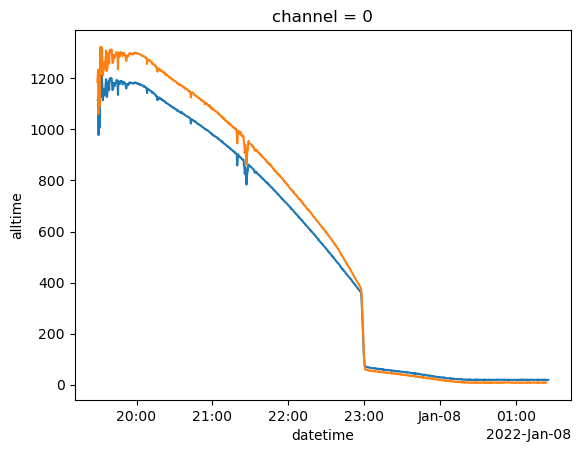

In [124]:
out.dataset.alltime.sel(channel = 0).plot()
outt.dataset.alltime.sel(channel = 0).plot()

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:124: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()


(<Figure size 1280x960 with 2 Axes>,
 <Axes: title={'center': 'channel = 0'}, xlabel='datetime', ylabel='direct_normal'>)

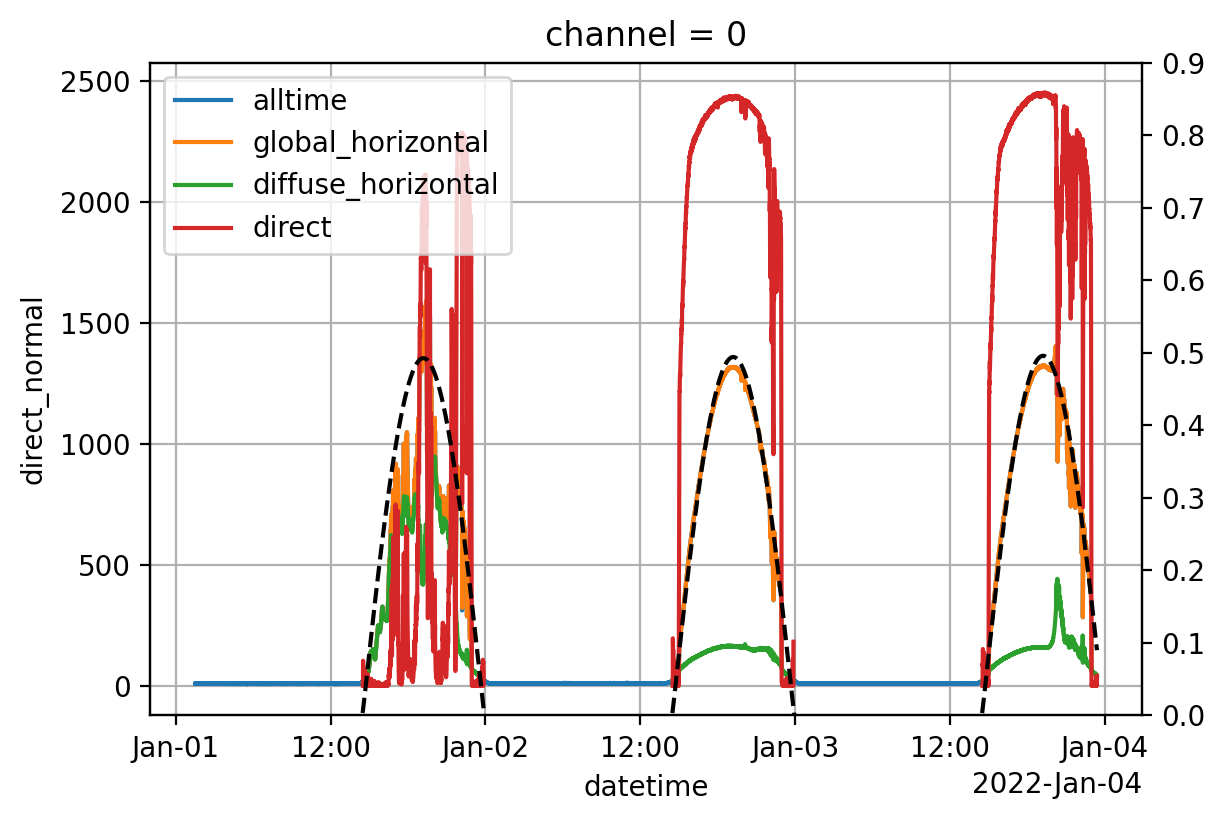

In [130]:
ops.plot_overview()

## mfrsr

In [157]:
p2fld = pl.Path('/nfs/grad/Inst/MFR/SURFRAD/tbl/mfrsr/raw/2025/tbl_mfrsr_20250131_181436.xmd')

In [126]:
p2fld = pl.Path('raw/BF4F.220103.mtm')
p2fld = pl.Path('raw/cbc_mfrsr_20220103_162303.xmd')
p2fld = p2fld.absolute()

In [5]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf

In [128]:
reload(atmsrf)

<module 'atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad' from '/home/grad/htelg/prog_dev/atm-py/atmPy/data_archives/NOAA_ESRL_GMD_GRAD/surfrad/surfrad.py'>

In [129]:
ops = atmsrf.read_raw(p2fld)

1 RSR files opened


/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:124: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()


(<Figure size 1280x960 with 2 Axes>,
 <Axes: title={'center': 'channel = 0'}, xlabel='datetime', ylabel='direct_normal'>)

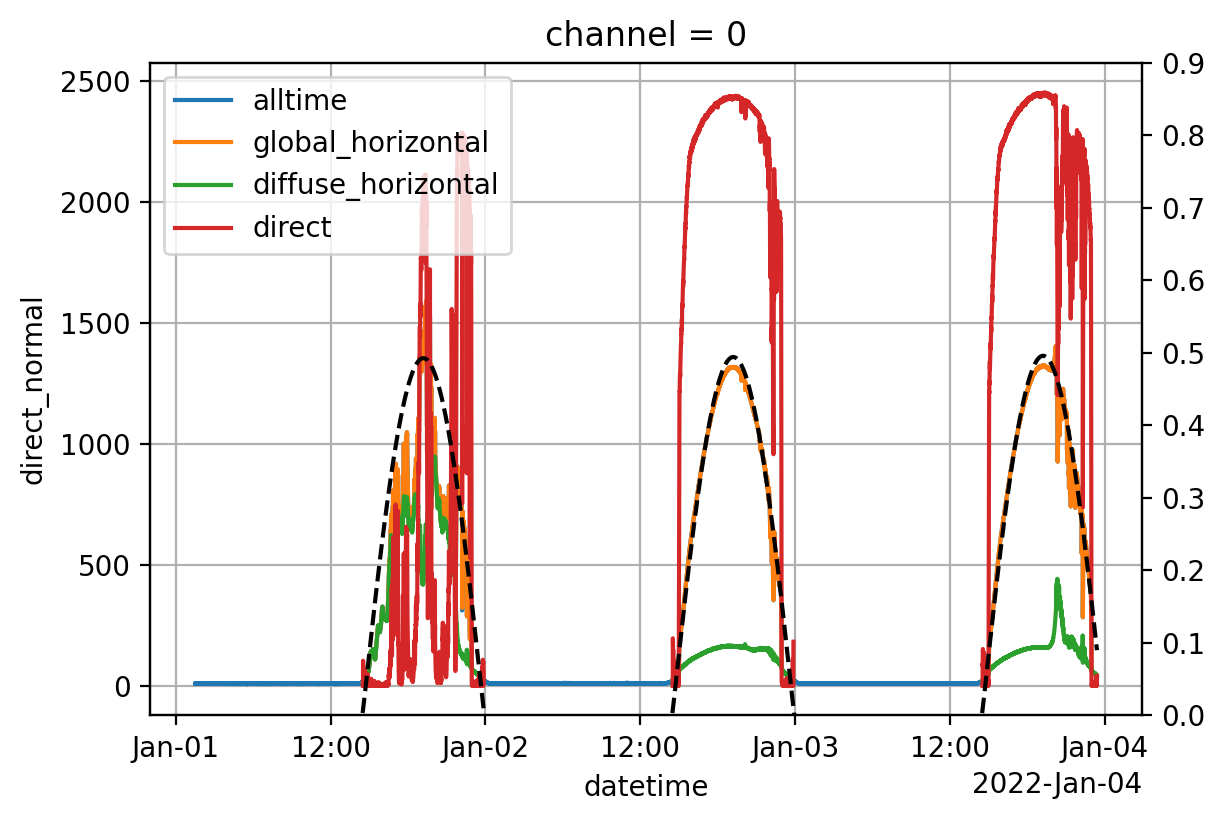

In [130]:
ops.plot_overview()

In [1]:
import os

In [2]:
# Add the new path to the PATH variable
os.environ["PATH"] += os.pathsep + "/home/grad/htelg/bin"
# os.environ["PATH"] += os.pathsep + "/home/hagen/bin"

In [3]:
import subprocess

In [4]:
import io

In [5]:
import atmPy.general.measurement_site as atmms

## read using tu

In [95]:
import atmPy.radiation.observations.spectral_irradiance as atmsirr


In [108]:
reload(atmsirr)

<module 'atmPy.radiation.observations.spectral_irradiance' from '/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/observations/spectral_irradiance.py'>

In [109]:
def read_file(path2file, read_header_only = False):
    command = f"tu -d joe -H {path2file.absolute()}"
    # print(command)
    out = subprocess.check_output(command, shell=True).decode()
    
    #### the header
    header = out.split('\n')[0]    
    if read_header_only:
        return header
    
    #### format the data
    df = pd.read_csv(io.StringIO(out), sep = r'\s+', header = None, skiprows=1)
    df.index = df.apply(lambda row: pd.to_datetime('19000101') + pd.to_timedelta(row[0] - 1, 'd'), axis = 1)
    df.index.name = 'datetime'
    df = df.where(df!=-9999)


    #### assign collumns
    attrs = dict(site_longitude = - float(header.split()[4]),
                 site_latitude = float(header.split()[3]),
                 site_elevation = 0,
                 site = 'TMP',
                 site_name = 'unknown',
                 calibrated_irradiance = False,
                 calibrated_cosine = False,
                 info = 'This is the raw file',
                 file_type = int(header.split()[0]),
                 serial_no = header.split()[1],
                 
                )
    
    di = 7
    si = 2
    alltime = df.iloc[:,si: si+di]
    si = 11
    global_horizontal = df.iloc[:,si: si+di]
    si =  18
    diffuse_horizontal = df.iloc[:,si: si+di]
    si =  25
    direct = df.iloc[:,si: si+di]
    
    for dft in [alltime, global_horizontal, diffuse_horizontal, direct]:
        dft.columns = range(7)
        dft.columns.name = 'channel'
    
    ds = xr.Dataset()
    # ds['sun_position'] = sun_position
    ds['alltime'] = alltime
    ds['global_horizontal'] = global_horizontal
    ds['diffuse_horizontal'] = diffuse_horizontal
    ds['direct_normal'] = direct
    ds.attrs = attrs
    
    obs = atmsirr.CombinedGlobalDiffuseDirect(ds)
    return obs

In [110]:
out = read_file(p2fld, read_header_only=False)
obs = out


1 RSR files opened


/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:124: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/pysolar/solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warnings.warn \


(<Figure size 1280x960 with 2 Axes>,
 <Axes: title={'center': 'channel = 0'}, xlabel='datetime', ylabel='direct_normal'>)

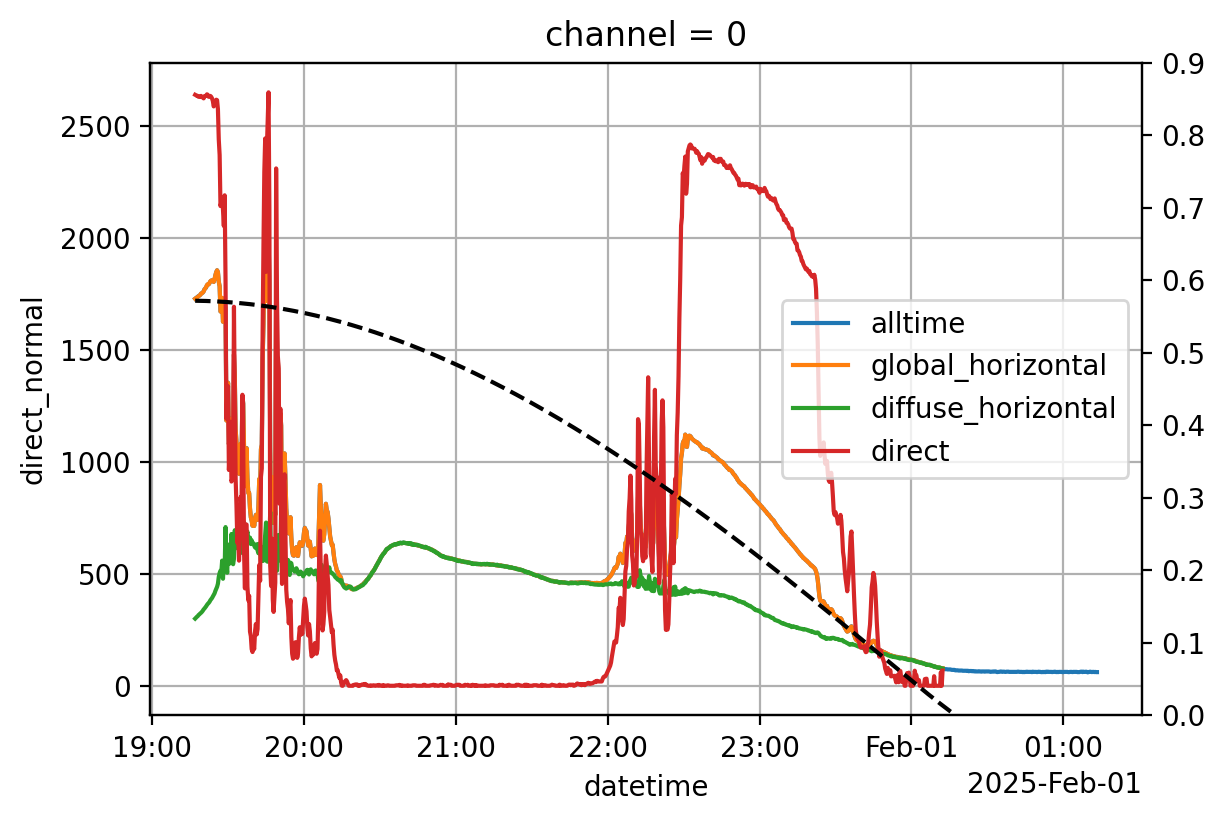

In [112]:
out.plot_overview()

## read using tu

In [83]:
command = f"tu -d joe -H {p2fld.absolute()}"
# print(command)
out = subprocess.check_output(command, shell=True).decode()

1 RSR files opened


In [27]:
df = pd.read_csv(io.StringIO(out), sep = r'\s+', header = None, skiprows=1)

In [41]:
# get datetime
df.index = df.apply(lambda row: pd.to_datetime('19000101') + pd.to_timedelta(row[0] - 1, 'd'), axis = 1)
df.index.name = 'datetime'

In [42]:
df = df.where(df!=-9999)

In [43]:
header = out.split('\n')[0]
header

'13 BF4F 97A4 38.853149 106.918945 20 20 20 44563 18020 7 0 11FF 0 113928 0'

In [44]:
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 05:00:19.583999922,44563.20856,2993,9,0,0,4,0,0,0,2171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03 05:00:40.320000025,44563.20880,2993,10,0,0,4,0,-1,-1,2171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03 05:01:00.191999844,44563.20903,2993,9,0,0,4,0,-1,-1,2171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03 05:01:20.064000285,44563.20926,2993,9,0,1,4,0,-1,-1,2171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03 05:01:39.936000095,44563.20949,2993,9,0,0,4,0,-1,-1,2171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 23:21:40.032000267,44563.97338,2995,43,108,40,6,11,14,11,2173,...,10.0,13.0,11.0,21.37,0.0,0.0,10.68,0.00,10.68,10.68
2022-01-03 23:21:59.904000077,44563.97361,2994,44,107,40,6,10,14,12,2173,...,10.0,12.0,11.0,0.00,0.0,0.0,0.00,0.00,21.58,10.79
2022-01-03 23:22:19.775999887,44563.97384,2995,43,106,39,6,10,15,12,2173,...,10.0,12.0,11.0,0.00,0.0,0.0,10.89,10.89,21.79,10.89


# separate columns to meaning 

In [45]:
attrs = dict(site_longitude = - float(header.split()[4]),
             site_latitude = float(header.split()[3]),
             site_elevation = 0,
             site = 'TMP',
             site_name = 'unknown',
             calibrated_irradiance = False,
             calibrated_cosine = False,
             info = 'This is the raw file'
            )
attrs

{'site_longitude': -106.918945,
 'site_latitude': 38.853149,
 'site_elevation': 0,
 'site': 'TMP',
 'site_name': 'unknown',
 'calibrated_irradiance': False,
 'calibrated_cosine': False,
 'info': 'This is the raw file'}

In [46]:
di = 7
si = 2
alltime = df.iloc[:,si: si+di]
si = 11
global_horizontal = df.iloc[:,si: si+di]
si =  18
diffuse_horizontal = df.iloc[:,si: si+di]
si =  25
direct = df.iloc[:,si: si+di]

In [47]:
for dft in [alltime, global_horizontal, diffuse_horizontal, direct]:
    dft.columns = range(7)
    dft.columns.name = 'channel'

In [48]:
ds = xr.Dataset()
# ds['sun_position'] = sun_position
ds['alltime'] = alltime
ds['global_horizontal'] = global_horizontal
ds['diffuse_horizontal'] = diffuse_horizontal
ds['direct_normal'] = direct
ds.attrs = attrs

In [49]:
import atmPy.radiation.observations.spectral_irradiance as atmsirr

In [50]:
reload(atmsirr)

<module 'atmPy.radiation.observations.spectral_irradiance' from '/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/observations/spectral_irradiance.py'>

In [51]:
obs = atmsirr.CombinedGlobalDiffuseDirect(ds)

In [52]:
obs.dataset

<xarray.Dataset> Size: 768kB
Dimensions:             (datetime: 3309, channel: 7)
Coordinates:
  * datetime            (datetime) datetime64[ns] 26kB 2022-01-03T05:00:19.58...
  * channel             (channel) int64 56B 0 1 2 3 4 5 6
Data variables:
    alltime             (datetime, channel) int64 185kB 9 0 0 4 0 ... 6 10 15 12
    global_horizontal   (datetime, channel) float64 185kB nan nan ... 15.0 12.0
    diffuse_horizontal  (datetime, channel) float64 185kB nan nan ... 14.0 11.0
    direct_normal       (datetime, channel) float64 185kB nan nan ... 11.11
Attributes:
    site_longitude:         -106.918945
    site_latitude:          38.853149
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    calibrated_cosine:      False
    info:                   This is the raw file

In [53]:
obs.sun_position

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:124: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()


,elevation,azimuth,airmass,sun_earth_distance,ampm
datetime,,,,,
2022-01-03 05:00:19.583999922,-1.008344,5.063351,-1.182103,0.983337,b'pm'
2022-01-03 05:00:40.320000025,-1.009445,5.064940,-1.181284,0.983337,b'pm'
2022-01-03 05:01:00.191999844,-1.010501,5.066466,-1.180501,0.983337,b'pm'
2022-01-03 05:01:20.064000285,-1.011555,5.067997,-1.179721,0.983337,b'pm'
2022-01-03 05:01:39.936000095,-1.012609,5.069532,-1.178944,0.983337,b'pm'
...,...,...,...,...,...
2022-01-03 23:21:40.032000267,0.093631,4.103358,10.695793,0.983335,b'pm'
2022-01-03 23:21:59.904000077,0.092730,4.104323,10.799508,0.983335,b'pm'
2022-01-03 23:22:19.775999887,0.091828,4.105287,10.905299,0.983335,b'pm'


# Test plots

Text(0.5, 1.0, 'global = alltime -> no cosine corretion applied')

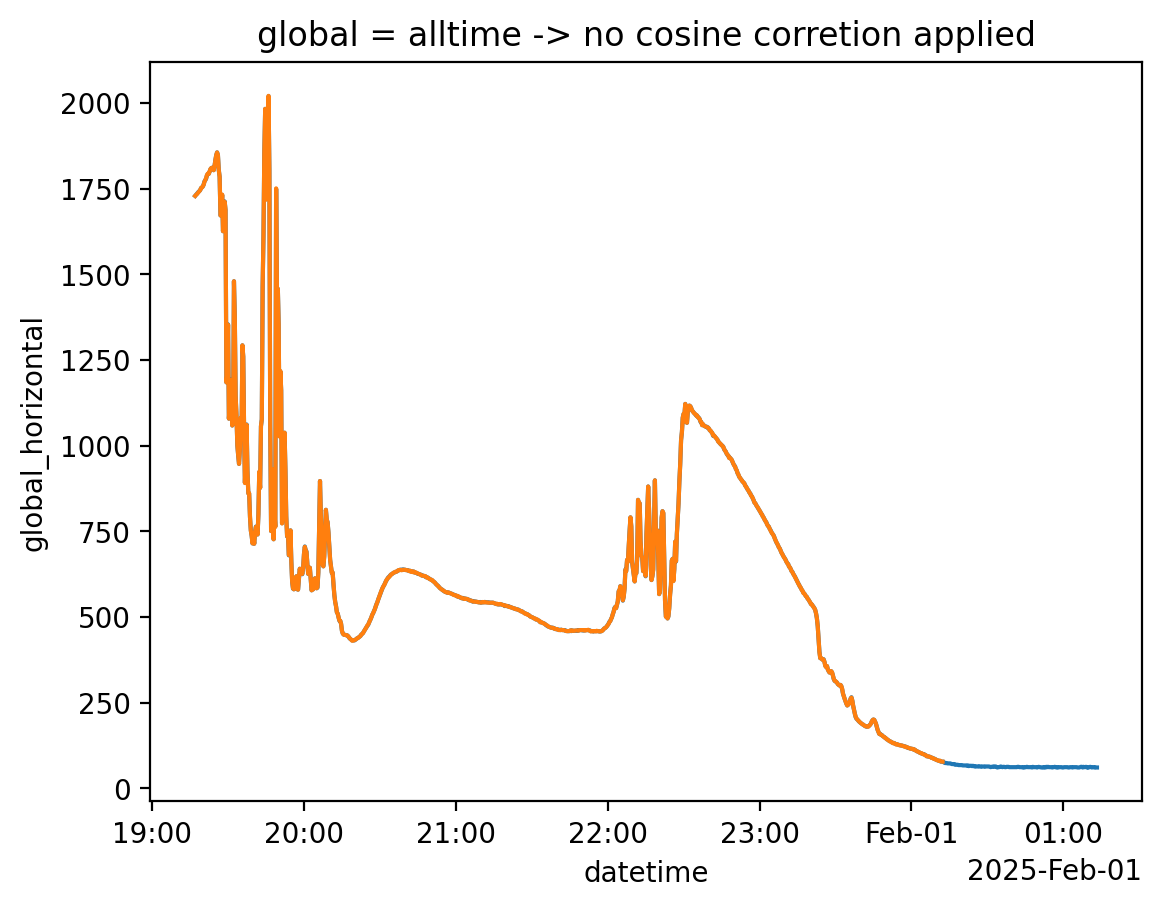

In [101]:
f,a = plt.subplots()
dssel = obs.dataset.sel(channel = 0)
dssel.alltime.plot(ax = a)
dssel.global_horizontal.plot(ax = a)
a.set_title('global = alltime -> no cosine corretion applied')

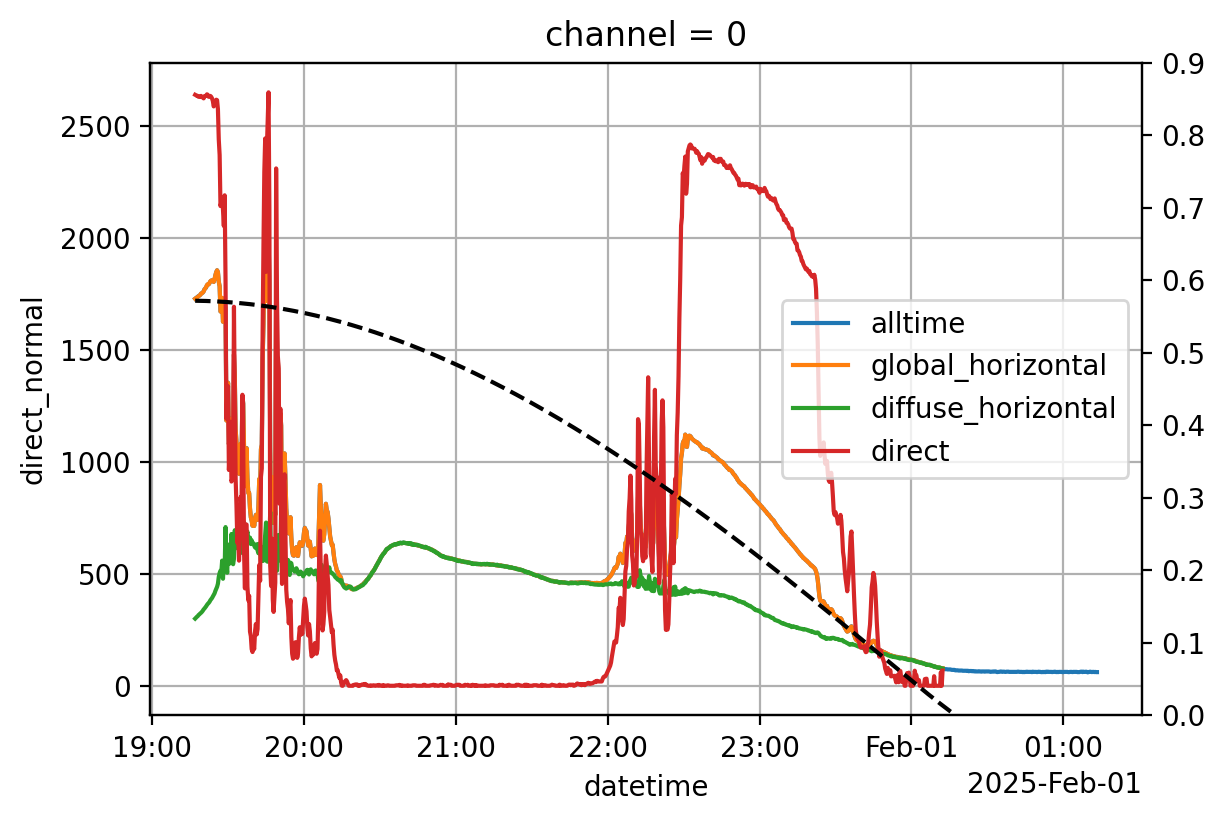

In [103]:
f, a= plt.subplots()
dssel = obs.dataset.sel(channel = 0)
dssel.alltime.plot(ax = a, label = 'alltime')

dssel.global_horizontal.plot(ax = a, label = 'global_horizontal')
dssel.diffuse_horizontal.plot(ax = a, label = 'diffuse_horizontal')
dssel.direct_normal.plot(ax = a, label = 'direct')

at = a.twinx()
obs.sun_position.elevation.plot(ax = at, color = 'black', ls = '--')
at.set_ylim(top = 0.9, bottom = 0)

# a.set_xlim(left = pd.to_datetime('20220103 14:00:00'))
a.grid()
a.legend()

In [ ]:
import matplotlib.pyplot

In [79]:
obs.sun_position.elevation

datetime
2022-01-03 05:00:19.583999922   -1.008344
2022-01-03 05:00:40.320000025   -1.009445
2022-01-03 05:01:00.191999844   -1.010501
2022-01-03 05:01:20.064000285   -1.011555
2022-01-03 05:01:39.936000095   -1.012609
                                   ...   
2022-01-03 23:21:40.032000267    0.093631
2022-01-03 23:21:59.904000077    0.092730
2022-01-03 23:22:19.775999887    0.091828
2022-01-03 23:22:39.647999706    0.090925
2022-01-03 23:23:00.383999809    0.089983
Name: elevation, Length: 3309, dtype: float64

<Axes: xlabel='datetime'>

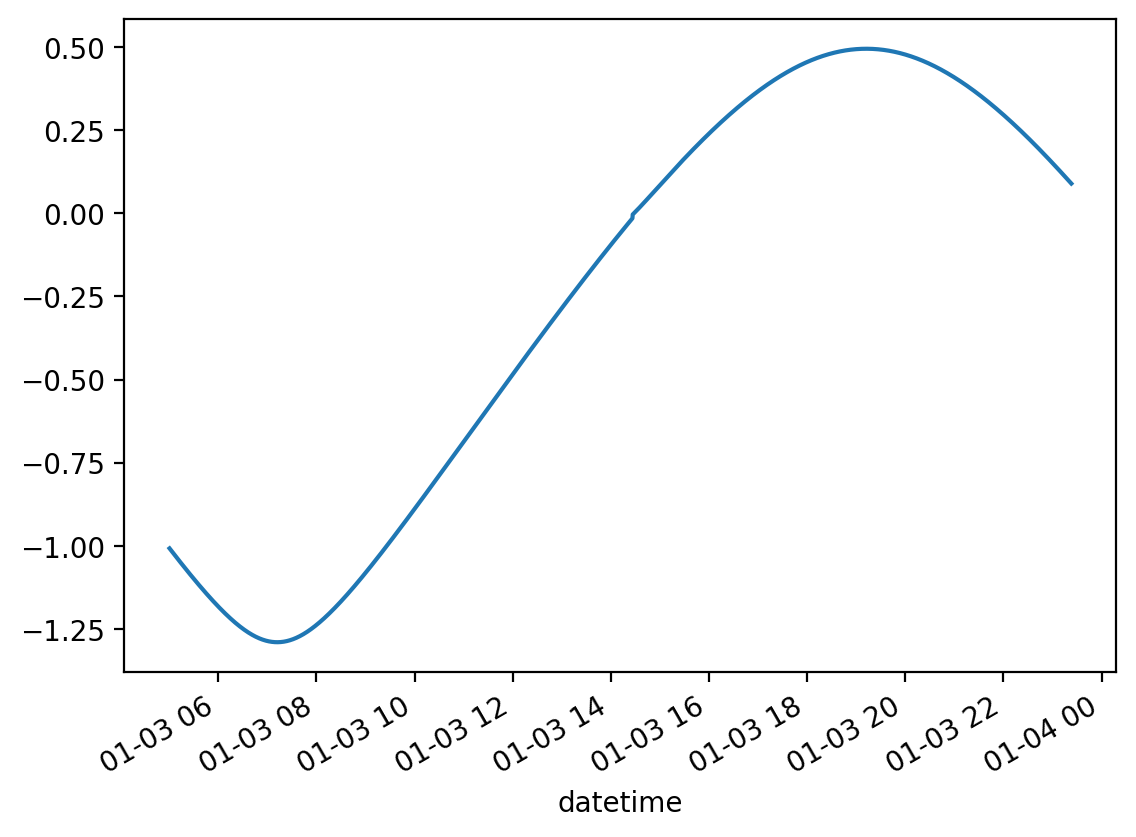

In [71]:
obs.sun_position.elevation.plot()

In [68]:
np.cos(obs.sun_position.elevation)

datetime
2022-01-03 05:00:19.583999922    0.533263
2022-01-03 05:00:40.320000025    0.532330
2022-01-03 05:01:00.191999844    0.531437
2022-01-03 05:01:20.064000285    0.530543
2022-01-03 05:01:39.936000095    0.529649
                                   ...   
2022-01-03 23:21:40.032000267    0.995620
2022-01-03 23:21:59.904000077    0.995704
2022-01-03 23:22:19.775999887    0.995787
2022-01-03 23:22:39.647999706    0.995869
2022-01-03 23:23:00.383999809    0.995954
Name: elevation, Length: 3309, dtype: float64

<Axes: xlabel='datetime'>

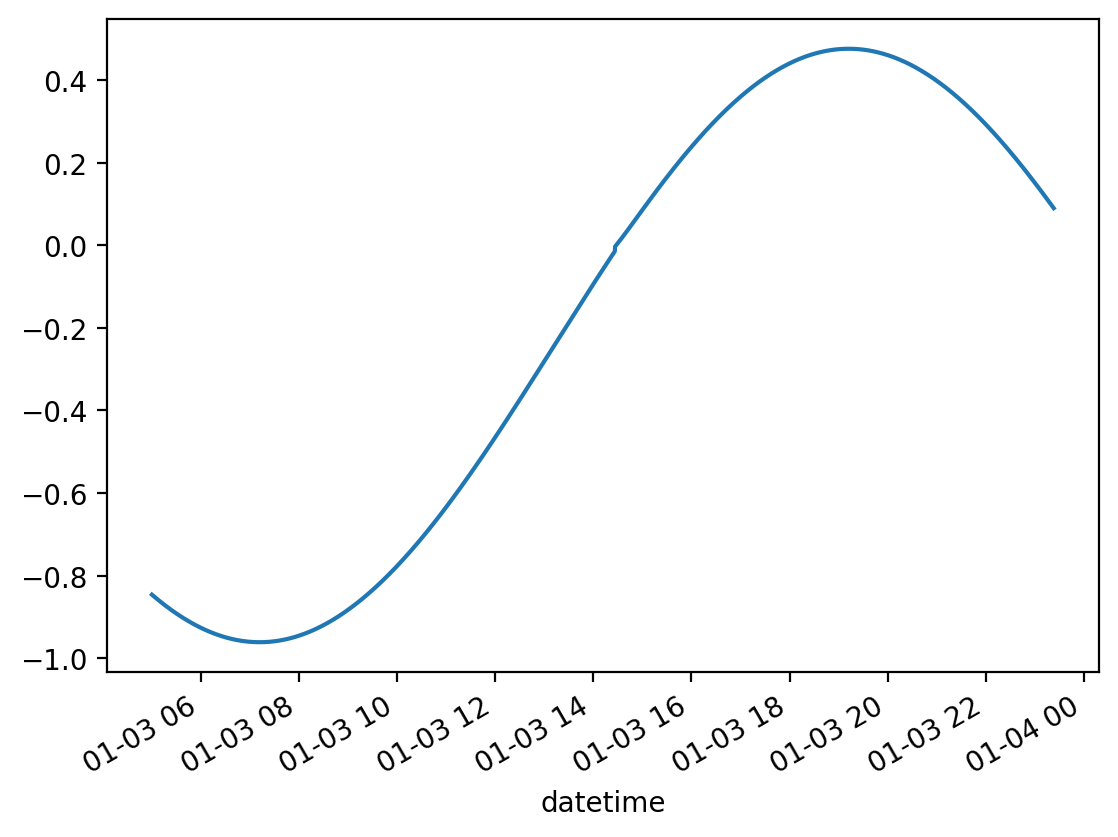

In [80]:
np.sin(obs.sun_position.elevation).plot()

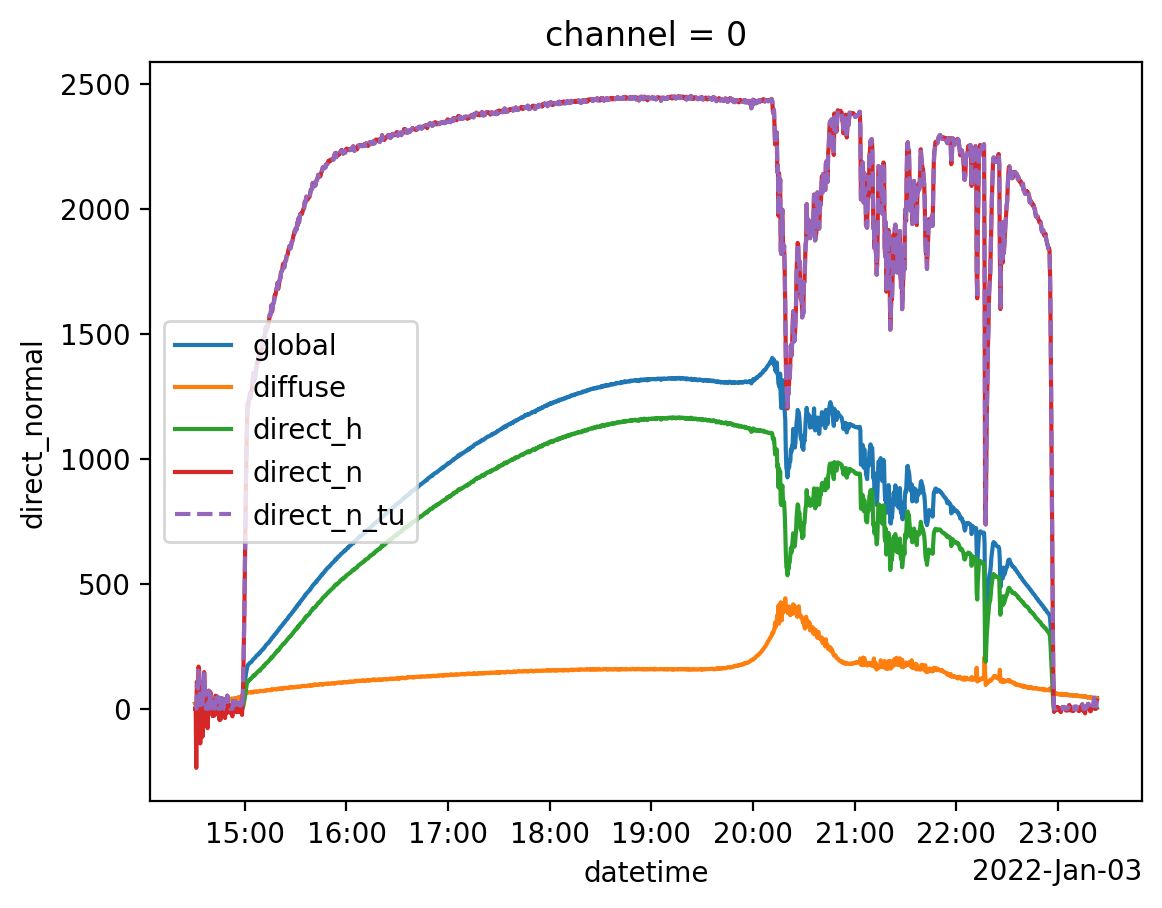

In [82]:
f,a = plt.subplots()
dssel.global_horizontal.plot(ax = a, label = 'global')
dssel.diffuse_horizontal.plot(ax = a, label = 'diffuse')
direct_horizontal = (dssel.global_horizontal - dssel.diffuse_horizontal)
direct_horizontal.plot(ax = a, label = 'direct_h')
direct_normal = direct_horizontal / np.sin(obs.sun_position.elevation)
direct_normal.plot(ax = a, label = 'direct_n')
dssel.direct_normal.plot(ax = a, label = 'direct_n_tu', ls = '--')
a.legend()

# convert time

In [61]:
row = df.iloc[0]

9


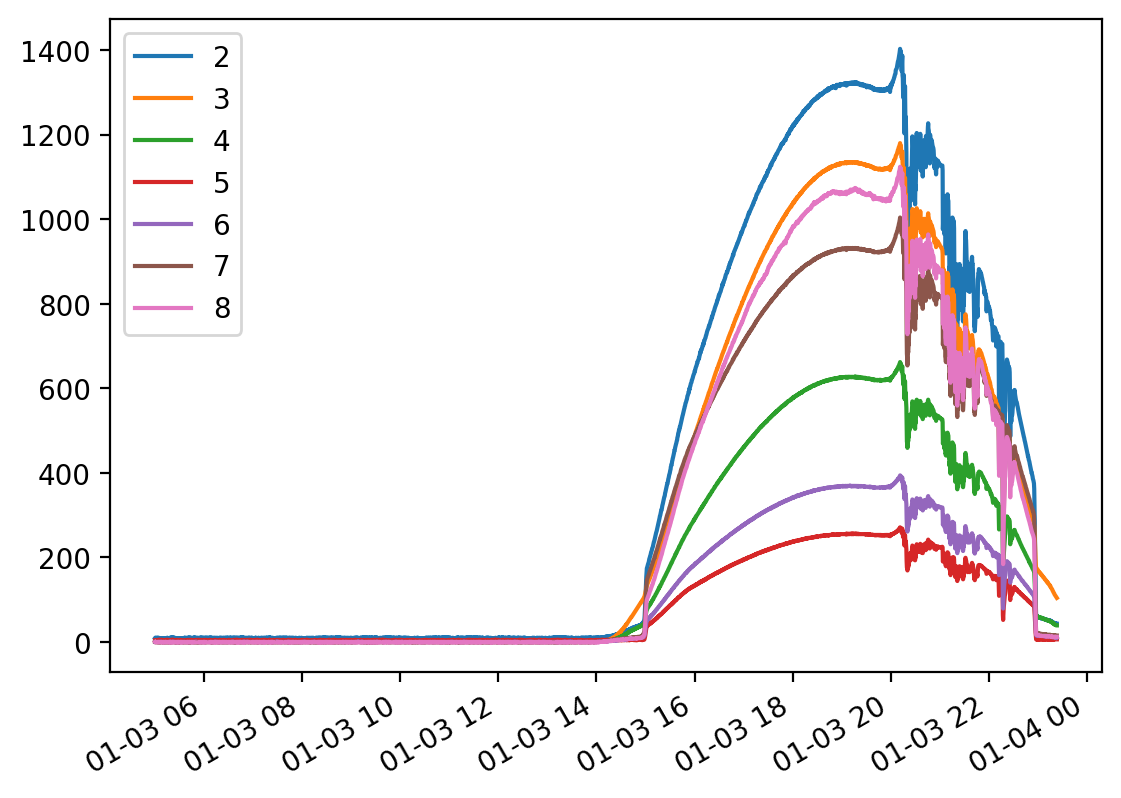

In [146]:
i = 8
i += 1
alltime = df.iloc[:,2:9]
.plot()#marker = '.', ls = '')
print(i)

(11, 18)

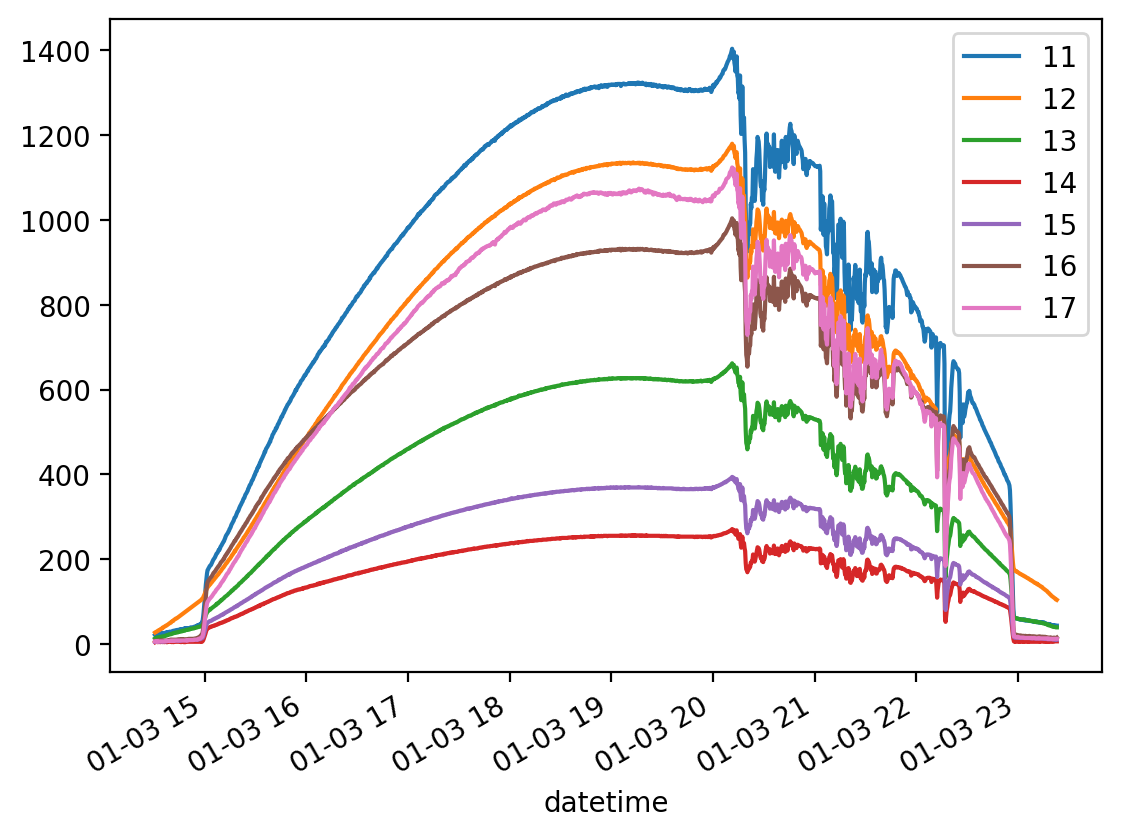

In [65]:
i = 11
# i += 1
di = 7
# di += 1
df.iloc[:,i:i + di].plot()#marker = '.', ls = '')
i, i+di

(18, 25)

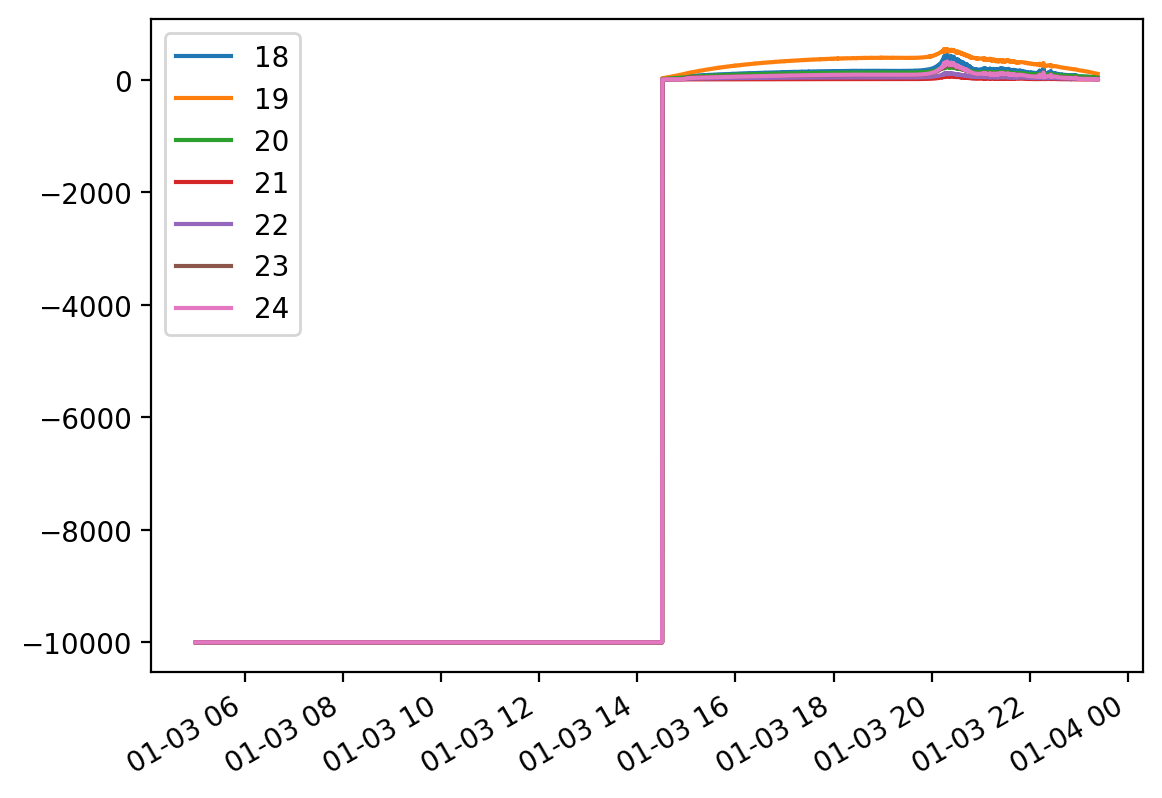

In [188]:
i = 18
# i += 1`
di = 7
# di += 1
df.iloc[:,i:i + di].plot()#marker = '.', ls = '')
i, i+di

(25, 32)

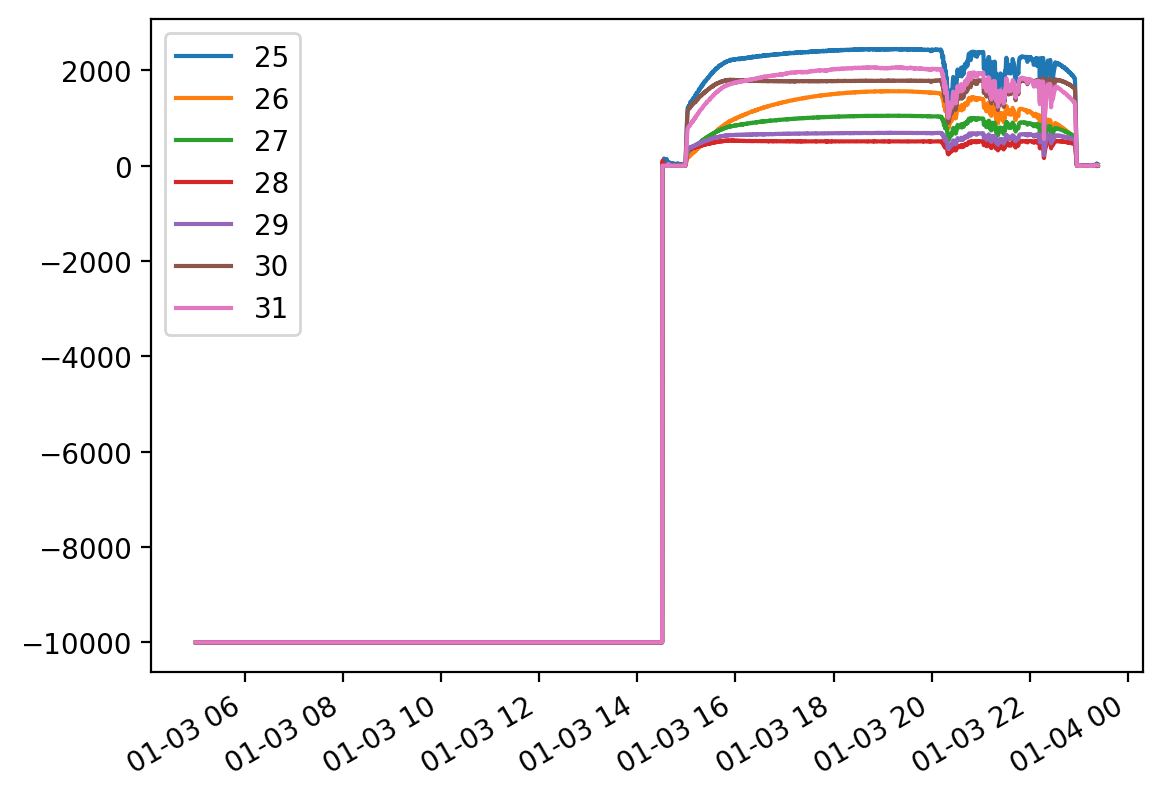

In [189]:
i = 25
# i += 1`
di = 7
# di += 1
df.iloc[:,i:i + di].plot()#marker = '.', ls = '')
i, i+di

9


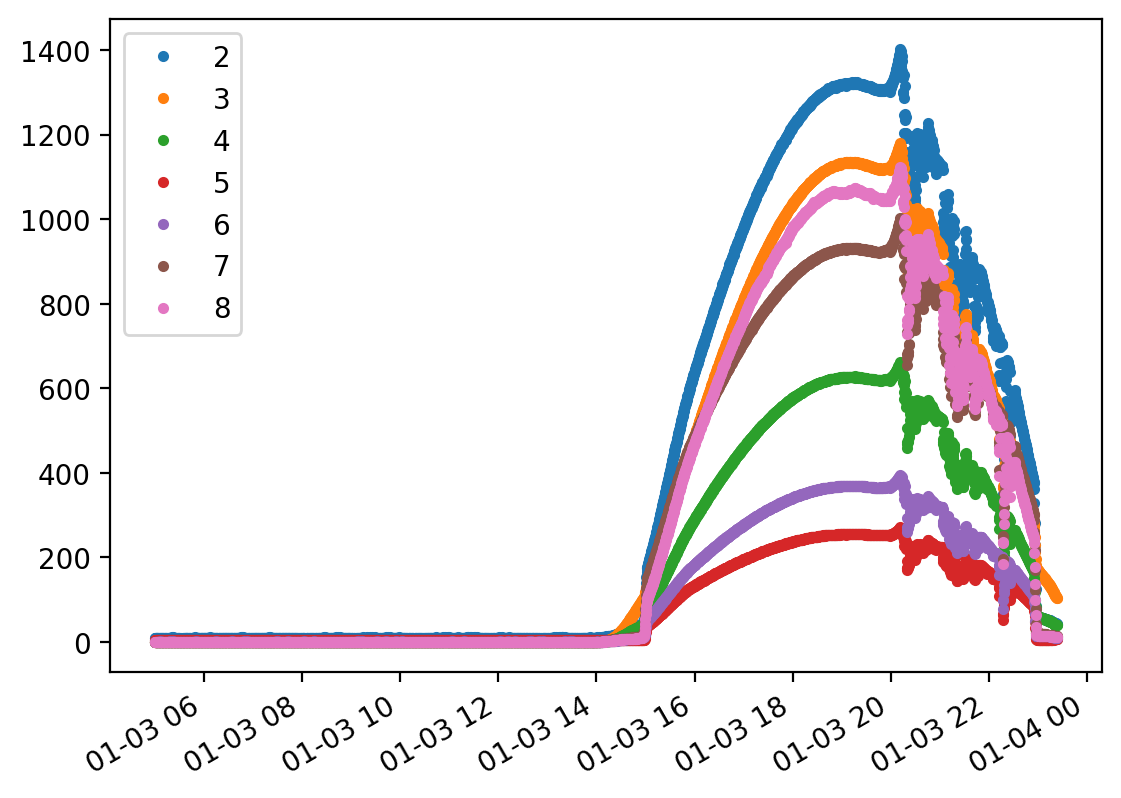

In [174]:
i = 8
i += 1
df.iloc[:,2:i].plot(marker = '.', ls = '')
print(i)

In [69]:
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
2022-01-03 05:00:19.583999922,44563.20856,2993,9,0,0,4,0,0,0,2171,...,-9999,-9999,-9999,-9999.00,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00
2022-01-03 05:00:40.320000025,44563.20880,2993,10,0,0,4,0,-1,-1,2171,...,-9999,-9999,-9999,-9999.00,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00
2022-01-03 05:01:00.191999844,44563.20903,2993,9,0,0,4,0,-1,-1,2171,...,-9999,-9999,-9999,-9999.00,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00
2022-01-03 05:01:20.064000285,44563.20926,2993,9,0,1,4,0,-1,-1,2171,...,-9999,-9999,-9999,-9999.00,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00
2022-01-03 05:01:39.936000095,44563.20949,2993,9,0,0,4,0,-1,-1,2171,...,-9999,-9999,-9999,-9999.00,-9999.0,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 23:21:40.032000267,44563.97338,2995,43,108,40,6,11,14,11,2173,...,10,13,11,21.37,0.0,0.0,10.68,0.00,10.68,10.68
2022-01-03 23:21:59.904000077,44563.97361,2994,44,107,40,6,10,14,12,2173,...,10,12,11,0.00,0.0,0.0,0.00,0.00,21.58,10.79
2022-01-03 23:22:19.775999887,44563.97384,2995,43,106,39,6,10,15,12,2173,...,10,12,11,0.00,0.0,0.0,10.89,10.89,21.79,10.89
2022-01-03 23:22:39.647999706,44563.97407,2994,43,105,39,6,11,15,12,2173,...,9,12,11,22.01,0.0,0.0,11.00,11.00,22.01,11.00


## date format: default

In [47]:
command = f"tu {p2fld.absolute()}"
print(command)
out = subprocess.check_output(command, shell=True).decode()

tu /home/grad/htelg/projects/ASR/splash/raw/BF4F.220103.mtm


1 RSR files opened


In [48]:
df = pd.read_csv(io.StringIO(out), sep = '\s+', header = None)

In [49]:
row = df.iloc[0]

In [55]:
str(int(row[0]))[1:]

'22'

In [56]:
f"{str(int(row[0]))[1:]}"

'22'

<Axes: >

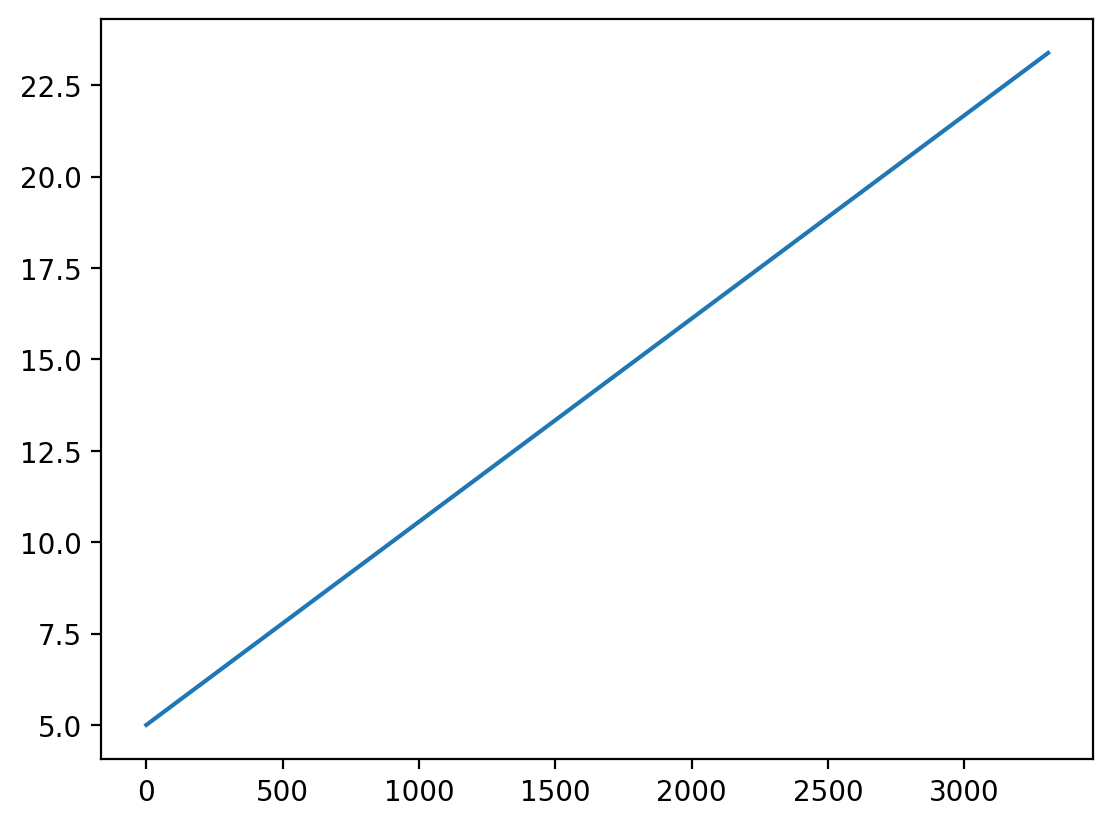

In [29]:
df.iloc[:,2].plot()

# read the cosine correction file